## Package Imports

In [7]:
import os
import pandas as pd

## Local Imports

In [4]:
from clock.config import connect

## Configuration

In [ ]:
%load_ext autoreload
#%autoreload 0 # -- Default
#%autoreload 1 # --Only auto-reload modules imported using aimport
%autoreload 2 # --Auto-reload all modules



In [5]:
engine, session = connect()

In [41]:
sql = '''
with frequency as (
    select total_days
         , count(employee_id) as frequency
    from attendance
    group by total_days
    order by total_days
), add_bins as (
    select case
               when total_days >= 240 and total_days <= 249 then '240-249'
               when total_days >= 250 and total_days <= 259 then '240-259'
               when total_days >= 260 and total_days <= 269 then '260-269'
               when total_days >= 270 and total_days <= 279 then '270-279'
               when total_days >= 280 and total_days <= 289 then '280-289'
               when total_days >= 290 and total_days <= 299 then '290-299'
               when total_days > 300 then '300+'
        end as bin
         , frequency
    from frequency
)
select bin
     , sum(frequency) as frequency
from add_bins
group by bin;

'''
df = pd.read_sql_query(sql, con=engine)

Attendance here is defined as someone who shows up for work in a given day, even if it is for
only a few minutes.  We can see that this follows a normal distribution, centered around the 270
 days of total attendance, with a few in the 240s and >300:

<AxesSubplot:xlabel='bin'>

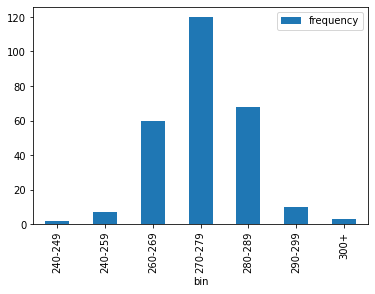

In [42]:
df.plot(x='bin', y='frequency', kind='bar')

We can take a look at the top 25 performers and see that universally they had 1200+ hours per year.

In [60]:
sql = '''
select employee_id
      , yearly_floor_time_hours
     , rank_best
from best_worst_25
where rank_best <= 25
order by rank_best;
'''
df = pd.read_sql_query(sql, con=engine)

In [66]:
df

,employee_id,yearly_floor_time_hours,rank_best
0,1,1359,1
1,0,1321,2
2,2,1301,3
3,55,1209,4
4,185,1203,5
5,265,1202,6
6,155,1201,7
7,72,1197,8
8,98,1194,9
9,210,1190,10


<AxesSubplot:xlabel='rank_best'>

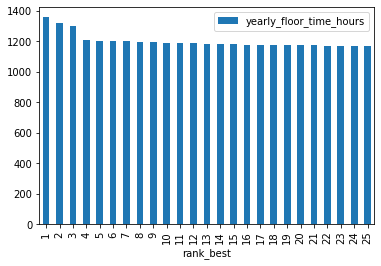

In [65]:
df.plot(x='rank_best', y='yearly_floor_time_hours', kind='bar')

In [ ]:
sql = '''
select employee_id
      , yearly_floor_time_hours
from best_worst_25
where rank_worst <= 25;
'''


We can take a look at the bottom 25 performers and see that there was little variance from
person-to-person; all had around 900-1000 hours annually:

In [71]:
sql = '''
select employee_id
      , yearly_floor_time_hours
     , rank_worst
from best_worst_25
where rank_worst <= 25
order by rank_worst;
'''
df = pd.read_sql_query(sql, con=engine)

In [72]:
df

,employee_id,yearly_floor_time_hours,rank_worst
0,15,950,1
1,209,963,2
2,137,965,3
3,148,985,4
4,218,986,5
5,138,989,6
6,158,996,7
7,157,1001,8
8,131,1009,9
9,160,1009,10


<AxesSubplot:xlabel='rank_worst'>

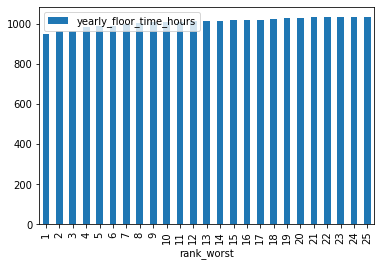

In [75]:
df.plot(x='rank_worst', y='yearly_floor_time_hours', kind='bar')

In [ ]:
sql = '''
select employee_id
      , yearly_floor_time_hours
from best_worst_25
where rank_worst <= 25;
'''